In [13]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness


In [14]:
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
train_dir="/kaggle/input/deepglobe-road-extraction-dataset/train/"

In [15]:
def sort_by_name(arr,separator):
    return sorted([f for f in arr if f.split(separator)[0].isdigit()],key=lambda x:int(x.split(separator)[0]))

In [16]:
#load data
def load_data(folder_path):
    folder=os.listdir(folder_path)
    sat_images=[]
    masks=[]
    for filename in folder:
        if filename.split('.')[1]=="jpg":
            sat_images.append(filename)
        elif filename.split('.')[1]=="png":
            masks.append(filename)
    sorted_sat_images=sort_by_name(sat_images,"_")
    sorted_masks=sort_by_name(masks,"_")
    return np.array(sorted_sat_images),np.array(sorted_masks)

In [17]:
sat_image_filenames,mask_filenames=load_data("/kaggle/input/deepglobe-road-extraction-dataset/train/")

In [18]:
def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    return

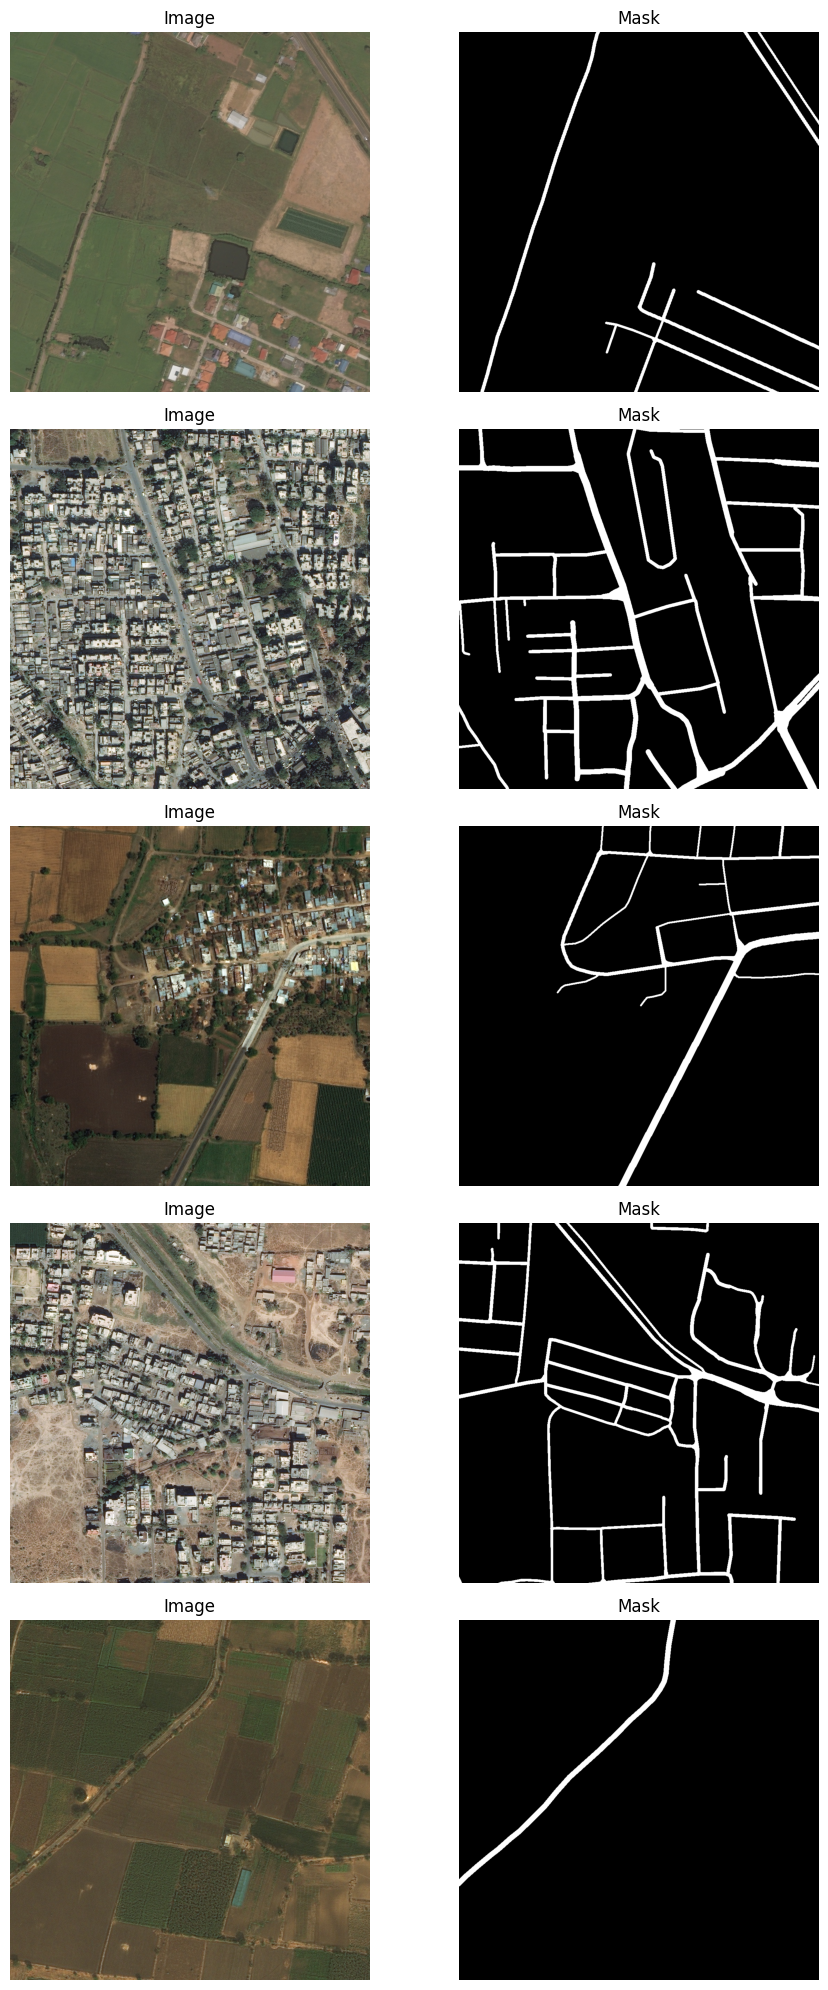

In [19]:
indices=random.sample(range(0,len(sat_image_filenames)),5)
display_data(train_dir,sat_image_filenames[indices],mask_filenames[indices])

In [20]:
#preprocessing
def preprocess_data(train_folder, sat_image_names, mask_names, input_size, augmented=False):

    sat_images = []
    masks = []
    for img_file, mask_file in zip(sat_image_names, mask_names):
        img = load_img(train_folder + img_file, target_size=input_size, color_mode='rgb')
        mask = load_img(train_folder + mask_file, target_size=input_size, color_mode='grayscale')

        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        mask_array = img_to_array(mask, dtype=np.bool_)

        # Append images and masks to the lists
        sat_images.append(img_array)
        masks.append(mask_array)

        if augmented:
            sat_images.append(flip_left_right(img_array))
            masks.append(flip_left_right(mask_array))

            sat_images.append(flip_up_down(img_array))
            masks.append(flip_up_down(mask_array))

    # Convert lists to numpy arrays
    sat_images = np.array(sat_images)
    masks = np.array(masks)

    return sat_images, masks


In [21]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [22]:
sat_images,masks=preprocess_data(train_dir,sat_image_filenames,mask_filenames,INPUT_SIZE)

In [23]:
print('Shape of image data: ' + str(sat_images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (6226, 256, 256, 3)
Shape of mask data: (6226, 256, 256, 1)


In [24]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(sat_images, masks, test_size=0.2, random_state=110)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=110)

In [26]:
import os
import numpy as np
import cv2  # OpenCV for image saving

# Define output directories
train_image_dir = '/kaggle/working/train_images'
val_image_dir = '/kaggle/working/val_images'
test_image_dir = '/kaggle/working/test_images'
train_mask_dir = '/kaggle/working/train_masks'
val_mask_dir = '/kaggle/working/val_masks'
test_mask_dir = '/kaggle/working/test_masks'

# Create directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)

# Function to save images
def save_images(images, masks, image_dir, mask_dir, start_index=0):
    for i in range(len(images)):
        img_path = os.path.join(image_dir, f'image_{start_index + i}.png')
        mask_path = os.path.join(mask_dir, f'mask_{start_index + i}.png')
        
        # Save image
        cv2.imwrite(img_path, images[i])
        
        # Convert mask from bool to uint8 (e.g., 0 and 255)
        mask_uint8 = (masks[i] * 255).astype(np.uint8)
        
        # Save mask
        cv2.imwrite(mask_path, mask_uint8)

# Example of how to call this function:
save_images(train_images, train_masks, train_image_dir, train_mask_dir)
save_images(val_images, val_masks, val_image_dir, val_mask_dir, start_index=len(train_images))
save_images(test_images, test_masks, test_image_dir, test_mask_dir, start_index=len(train_images) + len(val_images))


In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/models/save_best.keras', verbose=1, save_best_only=True)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose

def unet(input_shape, output_layer):
    inputs = Input(input_shape)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    #drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv5))
    merge6 = Concatenate()([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate()([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate()([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate()([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

In [29]:
model = unet(INPUT_SHAPE, output_layer=1)


In [30]:
optimizer = Adam()

# Compile the model with the optimizer instance
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
epochs = 20
history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])


Epoch 1/20


I0000 00:00:1726827729.072090     141 service.cc:145] XLA service 0x78d6f40035b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726827729.072178     141 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726827729.072186     141 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726827804.185509     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9565 - loss: 0.2613
Epoch 1: val_loss improved from inf to 0.15833, saving model to /kaggle/working/models/save_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 325s 980ms/step - accuracy: 0.9565 - loss: 0.2610 - val_accuracy: 0.9582 - val_loss: 0.1583
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9573 - loss: 0.1521
Epoch 2: val_loss improved from 0.15833 to 0.14703, saving model to /kaggle/working/models/save_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 219s 878ms/step - accuracy: 0.9573 - loss: 0.1521 - val_accuracy: 0.9582 - val_loss: 0.1470
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9580 - loss: 0.1413
Epoch 3: val_loss improved from 0.14703 to 0.12481, saving model to /kaggle/working/models/save_best.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 219s 882ms/step - accuracy: 0.9580 - loss: 0.1413 - val_accuracy: 0.9582 - val_loss: 0.1248
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0

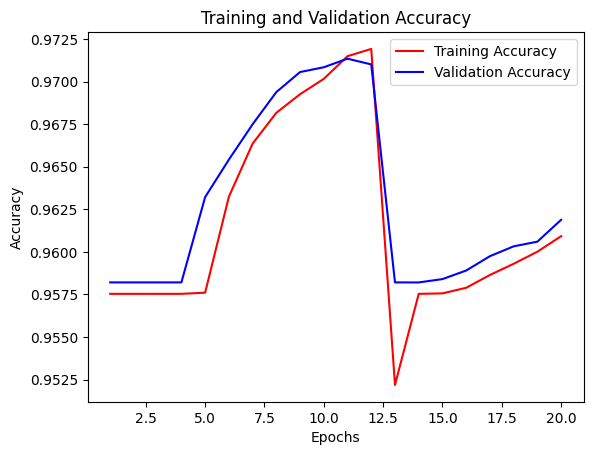

In [32]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
from tensorflow.keras.models import load_model

# Load the best saved model after training
best_model = load_model('/kaggle/working/models/save_best.keras')


In [34]:
best_model.save('/kaggle/working/models/roads_extraction.h5')


In [35]:
eval = best_model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 810ms/step - accuracy: 0.9704 - loss: 0.0831
Test accuracy: 0.97


In [36]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/roads_extraction.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


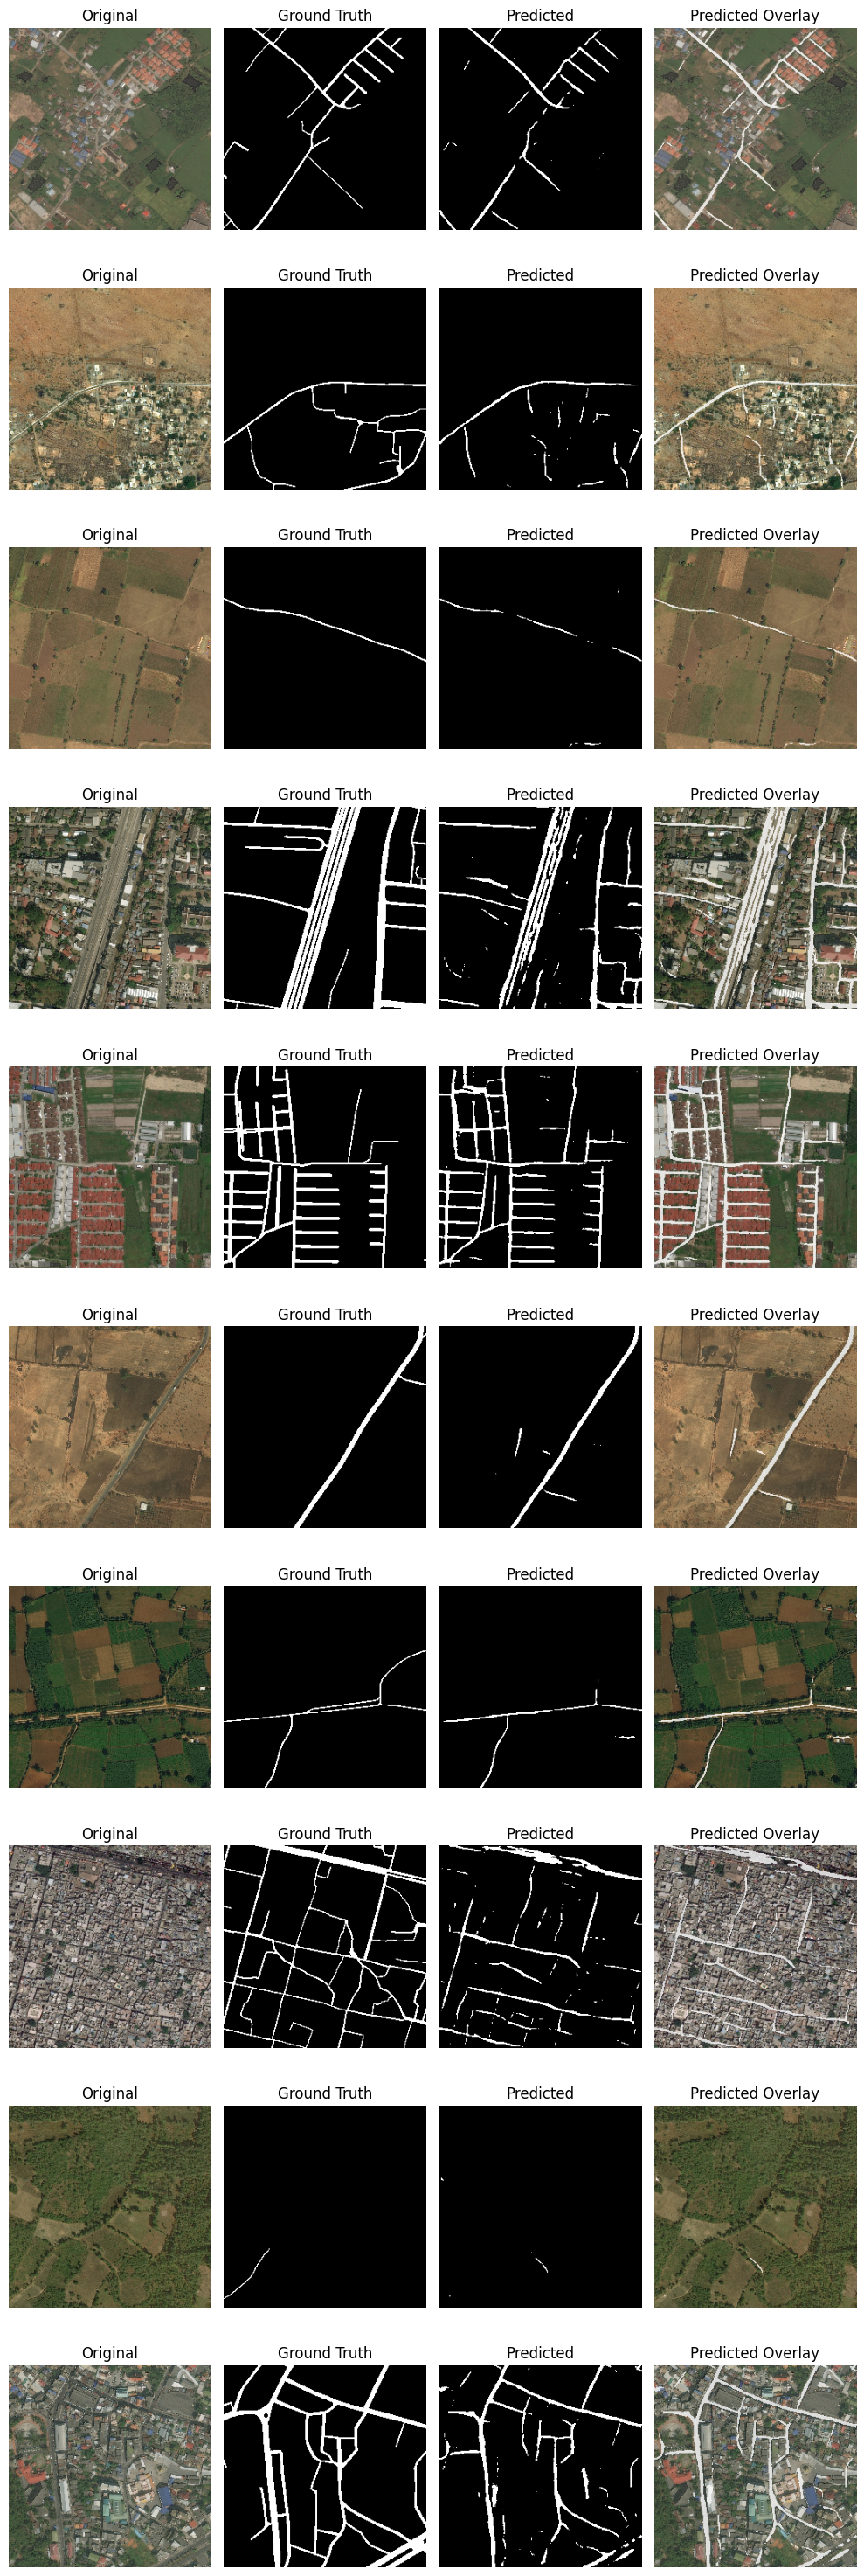

In [37]:
# display 10 random predictions
random.seed(50)
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()

In [38]:
predictions=model.predict(test_images)
predictions = (predictions > 0.5).astype(np.uint8)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step


In [40]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

# Flatten the 2D masks into 1D arrays
def flatten_masks(masks):
    return masks.reshape(masks.shape[0], -1)  # Flatten each image in the batch


# Flatten the masks and predictions (each image in the batch gets flattened)
flat_predictions = flatten_masks(predictions)
flat_test_masks = flatten_masks(test_masks)

# Initialize variables to hold cumulative scores
total_accuracy = 0
total_precision = 0
total_recall = 0
total_iou = 0
num_samples = predictions.shape[0]

# Loop through each sample and compute the metrics using scikit-learn
for i in range(num_samples):
    y_true = flat_test_masks[i]
    y_pred = flat_predictions[i]

    # Compute accuracy, precision, recall, and IoU
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    iou = jaccard_score(y_true, y_pred, zero_division=0)  # Jaccard index is the same as IoU

    # Accumulate the results
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_iou += iou

# Compute average metrics across all samples
avg_accuracy = total_accuracy / num_samples
avg_precision = total_precision / num_samples
avg_recall = total_recall / num_samples
avg_iou = total_iou / num_samples

# Print the results
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average IoU: {avg_iou:.4f}')


Average Accuracy: 0.9708
Average Precision: 0.6646
Average Recall: 0.5813
Average IoU: 0.4420
